# Numerical Methods
## Lecture 4: Numerical differentiation
by: [Tomasz Romańczukiewicz](mailto:trom@th.if.uj.edu.pl)

*********************************************************

### Outline
- Numerical differentiation
 - accuracy of finite difference methods: round-off *vs* method error
 - differentiation matrix
 - efficiency

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.dpi'] = 120
plt.rcParams['text.usetex']=True
plt.rcParams['font.size'] = 15

Derivatives:
* rarely calculating derivatives for the sake of calculating derivatives
* ordinary differential equations (ODE)
    - initial value problem 
    - two-point value problem
* stochastic differential equations (SDE)
* partial differential equations (PDE)
    - Black-Scholes, diffusion equation

## Using symbolic algebra

In [2]:
import sympy as sm
x = sm.symbols('x')
sm.diff(sm.sin(x),x)

cos(x)

In [8]:
d3f = sm.diff(sm.sin(x**2),x,3); d3f

-4*x*(2*x**2*cos(x**2) + 3*sin(x**2))

In [9]:
D3f = sm.lambdify(x, d3f)
D3f(1.0)

-14.420070264639875

## Automatic differentiation
Implement a class with overloaded operators and functions (chain rules)<br><br>
$$\begin{pmatrix}f\\f'\end{pmatrix}:\;\;\textrm{constant:}\begin{pmatrix}c\\0\end{pmatrix},\;\;\textrm{variable:}\begin{pmatrix}x\\1\end{pmatrix}$$
<br><br>

Addition
$$\begin{pmatrix}f_1\\f'_1\end{pmatrix}+\begin{pmatrix}f_2\\f'_2\end{pmatrix}
=\begin{pmatrix}f_1+f_2\\f'_1+f'_2\end{pmatrix}$$

Multiplication<br><br>
$$\begin{pmatrix}f_1\\f'_1\end{pmatrix}*\begin{pmatrix}f_2\\f'_2\end{pmatrix}
=\begin{pmatrix}f_1*f_2\\f'_1*f_2+f_1*f'_2\end{pmatrix}$$<br><br>
Functions:<br><br>
$$\sin\begin{pmatrix}f\\f'\end{pmatrix}
=\begin{pmatrix}\sin(f)\\-f'*\cos(f)\end{pmatrix}$$

$\Rightarrow$ Exercise

## Finite difference
Our goal is to learn how to solve numerically partial differential equation (PDE) such as the Black–Scholes equation

$$\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0.$$

But before we solve anything we have to understand how the derivatives are calculated by computers. 

Let us recall a definition

$$f'(x)=\lim_{h\to0}\frac{f(x+h)-f(x)}{h}=\lim_{h\to0}\frac{f(x)-f(x-h)}{h}.$$

Can we use this definition to calculate the derivative numerically?

But how to choose $h$? 

### Accuracy
If we take $h$ too large we will get an inacurate value (Taylor series)

$$f(x+h)\approx f(x)+f'(x)h+\frac{1}{2!}f''(x)h^2+\ldots=\sum_{n=0}^\infty\frac{f^{(n)}(x)}{n!}h^n$$


$$D_1(h)=\frac{f(x+h)-f(x)}{h}=\color{green}{f'(x)}+\color{red}{\frac{1}{2!}f''(x)h}+\frac{1}{3!}f'''(x)h^2+\ldots$$

Taking the average $\frac{1}{2}(D_1(h)+D_1(-h))$ we find a central difference scheme

$$D_2(h)=\frac{f(x+h)-f(x-h)}{2h}=\color{green}{f'(x)}+\color{red}{\frac{1}{6}f'''(x)h^2}+\mathcal{O}(h^4)$$

Both methods require calculation of $f$ twice, but the second gives smaller error ($h\ll 1$).

Forward difference:

$$D_{2f}(h)=\frac{-3f(x)+4f(x+h)-f(x+2h)}{2h}=\color{green}{f'(x)}+\color{red}{\frac{1}{3}f'''(x)h^2}+\mathcal{O}(h^3)$$

Note that central difference has twice smaller error than the forward difference, and in case of vanishing $f'''$ even the order is different. 

By taking a combination of more points, we can cancel higher terms of the Taylor expansion, for example from five points we obtain a fourth order five point-stencil method.

$$D_{\color{red}{4}}(h)=\frac{f(x-2h)-8f(x-h)+8f(x+h)-f(x+2h)}{12h}+\mathcal{O}(h^{\color{red}{4}})$$

__Note:__ because of the [Runge phenomenon](https://en.wikipedia.org/wiki/Runge's_phenomenon) higher order schemes for _evenly_ separated points are unadvised.

The list of the coefficients for central and forward can be found quite [easily](https://en.wikipedia.org/wiki/Finite_difference_coefficient)

Second and higher derivatives can also be found in the similar way:

$$\small f''(x)\approx D^2_4(h)=\frac{-f(x-2h)+16f(x-h)-30f(x)+16f(x+h)-f(x+2h)}{12h^2}+\mathcal{O}(h^4)$$

So, taking smaller $h$ always gives better results

<img src="yesbutno.jpg" alt="Drawing" style="width: 400px;"/>

#### Round-off errors
The numbers in computer have finite precision $x\in(a-\epsilon |a|, a+\epsilon|a|)$ have the same floating point value. 

$\epsilon=10^{-8}$ for floats and $10^{-16}$ for doubles. 

Subtracting similar values gives huge loss of the relative accuracy

$$1.2345678(\pm10^{-8})-1.2345666(\pm10^{-8})=0.0000012(\pm10^{-8})$$ 

but we have lost 6 significant digits!

$$\Delta_m(f(x+h)-f(x))\approx 2\epsilon |f|$$

We have two types of errors:

 - method error: $\Delta_m D_1=\frac{1}{2}f''\color{red}{h}$, 
 $\Delta_m D_2=\frac{1}{6}f'''\color{red}{h^2}$, _etc_
 - round off machine error: $\displaystyle\Delta_r D_n \sim \epsilon \frac{|f|}{\color{red}{h}}$
 
The best choice of $h$ minimizes the total error $\Delta=\Delta_m+\Delta_r=ah^n+bh^{-1}=\min$.<br>
This gives rough estimation for optimal $h\sim\epsilon^{1/(n+1)}$ and $\Delta\sim\epsilon^{n/(n+1)}$

In [5]:
def showTheoreticalError(n):
    plt.rcParams['text.usetex']=False
    with plt.xkcd():
        fig = plt.figure(figsize=(9,4.5))
        ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        title = 'Schematic error of the FDM for $\mathcal{O}$';
        plt.title('{:s}$(h^{:d})$'.format(title, n) )
        plt.xlabel('spaceing $h$')
        plt.ylabel("error $\Delta$")
        plt.xticks([])
        plt.yticks([])
        h = np.linspace(0.0001,5, 200)
        plt.ylim(0,5)
        plt.xlim(0,5)
        plt.plot(h, h**n, dashes=[4,2])
        plt.plot(h, 1/h, dashes=[2,2])
        plt.plot(h, 1/h+h**n)
        plt.legend('best')
        
        plt.legend(['method error $\Delta_m(h)$', 'machine error $\Delta_r$', 'total error $\Delta_m+\Delta_r$'])
        plt.show()
    plt.rcParams['text.usetex']=True

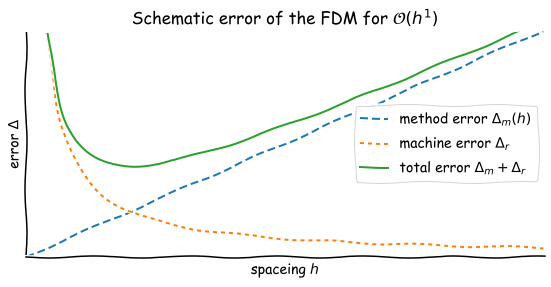

In [6]:
showTheoreticalError(n=1)

In [7]:
def D1(x, h, f):  # First order FD
    return (f(x+h)-f(x))/h;

def D2(x, h, f): # 2nd order FD
    return (f(x+h)-f(x-h))/(2*h);

def D4(x, h, f): # 4th order FD
    return (f(x-2*h)-8*f(x-h)+8*f(x+h)-f(x+2*h))/(12*h)

def f (x): # Example function
    return np.sin(x);

h = np.logspace(-16, 0, num=500, endpoint=True)  # scan through different h
x = 1.0;
D1f = D1(x, h, f);
df = np.cos(x);  # exact f'
Error1 = np.abs(D1f-df);
Error2 = np.abs(D2(x, h, f)-df);
Error4 = np.abs(D4(x, h, f)-df);

In [8]:
import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')
plt.rcParams['text.usetex']=True
plt.rcParams['figure.dpi'] = 120

def plot_FD_errors():
    plt.figure(figsize=(6,3.5), dpi=150)
    plt.title('Error of the finite difference methods for $f(x)=\sin(x)$')
    plt.xlabel('$h$')
    plt.ylabel("$|D_nf - f'|$")
    plt.grid(True)
    plt.loglog(h, Error1, basex=10)
    plt.loglog(h, Error2, basex=10)
    plt.loglog(h, Error4, basex=10)
    plt.legend('best')
    plt.legend(['$\mathcal{O}(h)$', '$\mathcal{O}(h^2)$', '$\mathcal{O}(h^4)$'])
    plt.show()

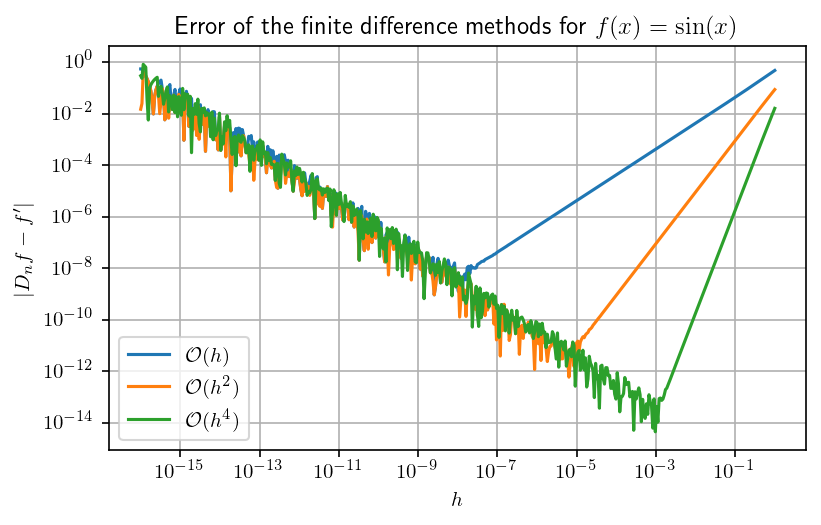

In [9]:
plot_FD_errors()

**Note** that in the first order scheme we lose up to 8 significant digits for the **best** choice of $h$! The relative error grew $10^8$ times.<br>
Other schemes are better with the best accuracy $\Delta\sim \epsilon^{n/(n+1)}$

Can we do better:
For the $\mathcal{O}(h^2)$ symmetric scheme we have

$$D_2(h) = f'+\alpha_2 h^2f'''+\alpha_4 h^4 f^{(v)} + \alpha_6 h^6f^{(vii)} + \cdots$$

$$D_2(h/2) = f'+\frac{1}{4}\alpha_2 h^2f'''+\frac{1}{16}\alpha_4 h^4f^{(v)} + \frac{1}{64}\alpha_6 h^6f^{(vii)}+ \cdots$$

$$\frac{4D_2(h/2)-D_2(h)}{3} = {\color{green}{f'}} - \color{red}{\frac{\alpha_4f^{(v)}h^4}{4}} +\frac{5\alpha_6 f^{(vii)}h^6}{16}+\cdots$$

Using twice $\mathcal{O}(h^2)$ scheme we can obtain $\mathcal{O}(h^4)$ result.<br>
Calculating $D_2(h/4)$ we can cancel higher terms


<div class="alert alert-block alert-warning">
<b>Surprisingly,</b>     it is sometimes easier to calculate an integral to calculate the derivative
    
$$f^{(n)}(a)=\frac{n!}{2\pi i} \oint _{\gamma}\frac{f(z)}{(z-a)^{n+1}}$$

</div>


### Discretization. Differentiation matrix.

Let us introduce a grid: $x_n=nh, n=0,\ldots,N-1$.<br>
Function $f(x)$ can be stored as a vector $y_n=f(x_n)$.

A vector of the first derivatives $y'_n\approx f'(x_n)$ can be calculated (using central $\mathcal{O}(h^2)$ scheme):

$$y'_n=\frac{-y_{n-1}+y_{n+1}}{2h},\qquad n>0 \wedge n<N-1.$$

Note, that for $n=0$ and $n=N-1$ we would need to know $y_{-1}$ and $y_N$.<br> They can be found either from boundary conditions, or from symmetries (pairity, periodicity etc).

Alternatively we could use appropriate forward or backward schemes:

$$y'_0=\frac{-3y_0 + 4y_1 -y_2}{2h}$$

$$y'_{N-1}=-\frac{-3y_{N-1} + 4y_{N-2} -y_{N-3}}{2h}$$

All these expressions can be written in a matrix form $y'=Dy$ where $y,y'\in\mathbb{R}^{N}, D\in\mathbb{R}^{N\times N}$

$${\scriptsize D=\frac{1}{2h}\left(\begin{array}{rrrrrrrrr}
-3& 4&-1\\
-1& 0& 1\\
& -1& 0& 1\\
&& -1& 0& 1\\
&&&\ddots&\ddots&\ddots\\
&&&&&-1& 0& 1\\
&&&&& 1& -4& 3
\end{array}
\right)}$$

**Remarks**
1. The first and the last row can be different when we know more about the symmetry of $f$.
2. For nonuniform grid the entries differ but the 3-diag structure remains.
3. Similar matrices can be found for higher orders of FD (more diagonals) and higher derivatives.
4. A linear differential equation $y'=g(x)$ becomes an algebraic equation $Dy=g$.
5. $D$ is singular (rank: $N-1$) so ODE requires one more condition, such as $y_0=y(0)=a$.

### Efficiency
Let us compare times needed to calculate 

$$y''_n\approx\frac{1}{12h^2}(-y_{n-2}+16y_{n-1}-30y_n+16y_{n+1}-y_{n+2})$$ 

for a whole vector without boundary points.

In [10]:
import time

def measure_time_Derivative2_loop(y, h, N, D): 
    fac = (12*h*h);    start = time.time()
    dy = []
    for n in range(2, N-3):
        dy.append( (-y[n-2]+16*y[n-1]-30*y[n]+16*y[n+1]-y[n+2])/fac );
    return time.time()-start, dy

def measure_time_Derivative2_vectorize(y, h, N, D):    
    fac = (12*h*h);    start = time.time()
    dy = (-30/fac)*y[2:N-3] + (16/fac)*(y[1:N-4]+y[3:N-2]) - (1/fac)*(y[0:N-5]+y[4:N-1]);
    return time.time()-start, dy

def measure_time_Derivative2_matrix(y, h, N, D):
    start = time.time()
    dy = D*y
    return time.time()-start, dy

In [11]:
import scipy.sparse as sp  # povides sparse matrices

def init_vectors(N):
    x = np.linspace(-10, 10, N);  # grid points
    y = np.exp(-x**2);            # example function 
    h = x[1]-x[0]                 # grid spaceing
    u = np.ones(N)/(12*h*h)  
    data = np.array([-u, 16*u, -30*u, 16*u, -u])  # array Nx5 to fill the matrix
    diags = np.array([-2, -1, 0, 1, 2])           # which diagonals to fill 
    D_sparse = sp.spdiags(data, diags, N, N)      # sparse 5-diagonal matrix 
    return h, x, y, D_sparse

N=10000
h, x, y, D = init_vectors(N)
T1, dy = measure_time_Derivative2_loop(y, h, N, D)
T2, dy = measure_time_Derivative2_vectorize(y, h, N, D)
T3, dy = measure_time_Derivative2_matrix(y, h, N, D)
D_full = D.toarray();   # Full matrix from sparse D
T4, dy = measure_time_Derivative2_matrix(y, h, N, D_full)    

print ("{:e}  {:e}  {:e}  {:e}".format(T1, T2, T3, T4))
print ("Vectorization is {:.2f} times faster than loops".format(T1/T2))
print ("Vectorization is {:.2f} times faster than sparse matrix multiplication".format(T3/T2))
print ("Full matrix multiplication is {:.2f} slower than sparse".format(T4/T3))

2.020621e-02  7.534027e-05  1.223087e-04  4.062111e-01
Vectorization is 268.20 times faster than loops
Vectorization is 1.62 times faster than sparse matrix multiplication
Full matrix multiplication is 3321.19 slower than sparse


In [12]:
def measure_all_times(N, iterations):
    N = int(N)
    h, x, y, D = init_vectors(N) 
    A = [N]
    for f in [measure_time_Derivative2_loop, measure_time_Derivative2_vectorize, measure_time_Derivative2_matrix]:
        
        T = []
        for k in range(iterations):
            t, dy = f(y, h, N, D)
            T.append(t*1e6)            
        A.append(np.sum(np.sort(T)[2:-2])/(iterations-4))

    if (N<10000):  ## Full matrix is slow, so we measure it only for small N
        f = measure_time_Derivative2_matrix
        D_full = D.toarray()
        
        T = []
        for k in range(iterations):
            t, dy = f(y, h, N, D_full)
            T.append(t*1e6)            
        A.append(np.sum(np.sort(T)[2:-2])/(iterations-4))
    else:
        A.append(np.nan);

    return A;

def measure_times_through_N():
    measured_times = []
    measure_points_number=50
    for N in np.linspace(1, 5, measure_points_number):
        A = measure_all_times(10**N, 15)
        measured_times.append(A)

    measured_times = np.reshape(measured_times, (measure_points_number,5))    
    np.savetxt('speed_measurements.dat', measured_times)
    
def show_measured_times():
    import warnings
    warnings.filterwarnings('ignore')
    measured_times = np.loadtxt('speed_measurements.dat')
    plt.figure(figsize=(9,4.5))
    plt.title('Calculation time')
    plt.xlabel('$N$')
    plt.ylabel("Time $t [\mu s]$")
    plt.grid(True)
    plt.loglog(measured_times[:,0], measured_times[:,1:5], basex=10)
    C = np.loadtxt('Ctests/CSpeedKing.dat', usecols=range(2))
    plt.loglog(C[:,0], C[:,1], basex=10, dashes=[2,2], color='black')
    plt.legend(['loop', 'vectorisation', 'sparse matrix', 'full matrix', 'C simple loop'])
    plt.show()

### Why so sparse?

$${\scriptsize \begin{array}{rcccc}
\ \text{Operation}\  &
\ \text{Full matrix}  \ & \ \text{Sparse (5-diag) matrix} \ & \ \text{Loops} \ & \ \text{Vectorization} \ \\
\hline\hline
\text{Preparation } (D, y)& \mathcal{O}(N^2) & \mathcal{O}(N) & \mathcal{O}(N\log N)^* &\mathcal{O}(N) \\
\text{Multiplication } Dv& \mathcal{O}(N^2) & \mathcal{O}(N) & \mathcal{O}(N) &\mathcal{O}(N)\\
\text{Solving } Dy=g& \mathcal{O}(N^3) & \mathcal{O}(N) & \text{iterative} & \text{iterative} \\
\hline
\end{array}}$$

$^*$ append reallocates list doubling its length, but preallocation is not always faster. 

Standard loops have a large coefficient, some $10-100$ larger than vectorization.

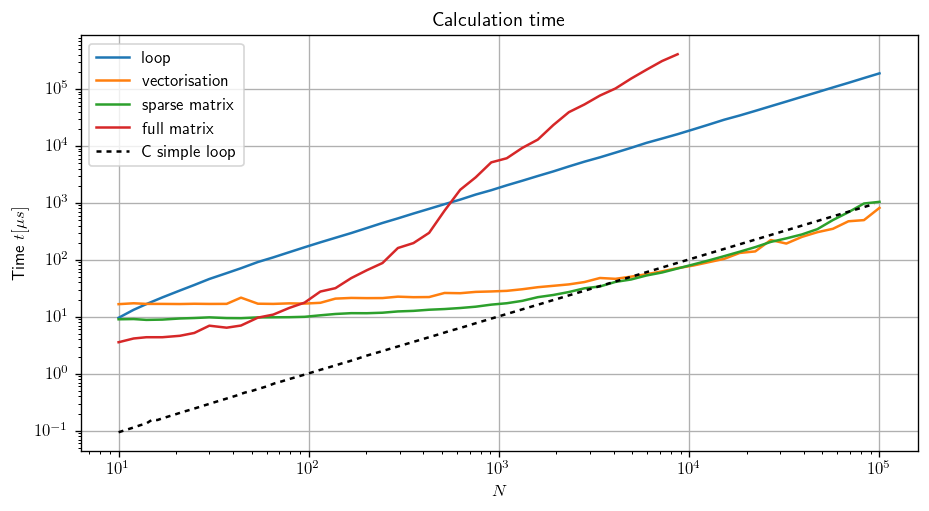

In [13]:
# measure_times_through_N()
show_measured_times()

Note that loops in C/C++ can be faster than vectorization in Python, there is no need to create temporary array objects.

Low level language can scan memory more efficiently and can use registers (eg. BLAS library). 

The function $\equiv$ values at certain points $y_i=f(x_i)$ but we can choose different parametrization (basis):
 * Polynomial base $\displaystyle f(x)=\sum_{n=0}^Na_nx^n$
  $$f'(x)=\sum_{n=0}^Nn a_nx^{n-1}=\sum_{n=0}^{N-1}\color{red}{(n+1) a_{n+1}}x^{n}$$ 
  
  The derivative:
  
  $$\vec a'=D\vec a,\qquad D=\left(
  \begin{array}{ccccc}
  0&0&0&0&\cdots\\
  1&0&0&0&\cdots\\
  0&2&0&0&\cdots\\
  0&0&3&0&\cdots\\
  &&{\cdots}&&
  \end{array}
  \right)$$
  
  Note: Monomials with high order are very bad for numerical calculation (better: use orthogonal basis)

 * Fourier basis $\displaystyle f(x)=\sum_{n=0}^Nc_ne^{inx}$
 
 $$f'(x)=\sum_{n=0}^N\color{red} {inc_n}e^{inx},\quad\Rightarrow\quad D_{nm}=in\delta_{nm}$$
 
 To switch between $c_n$ (Fourier) and $y_n$ (real) spaces uses Fast Fourier Transform (FFT).
 This matrix transformed to the real space is full not sparse.
 

 * Chebyshev basis $\displaystyle f(x)=\sum_{n=0}^Nc_nT_n(x)$ where $T_n(x)=\cos(n\mathop{\text{acos}} x)$
   (again results in full matrix). 
   
Full matrices use all available information resulting in great accuracy $O(10^{-\alpha N})$.
 

In [14]:
def show_Fourier_coeffs(N = 30):
    x = np.linspace(0, 2*np.pi, N, endpoint=False)
    n = np.arange(N)
    y = 1 + 2*np.sin(5*x)+0.5*np.cos(10*x) + np.exp(-11j*x)
    y_fft = np.fft.fft(y)/N
    plt.figure(figsize=(6,3), dpi=150)
    plt.step(n+0.5, np.real(y_fft))
    plt.step(n+0.5, np.imag(y_fft))
    plt.grid(True)
    plt.legend(['re$f$', 'im$f$'])
    plt.xlabel('$n$')
    plt.ylabel('$c_n$')
    
    plt.show()


$$f(x) = 1 + 2\sin(5\,x)+\frac 12\cos(10\,x) + \exp(-11 i\, x)$$


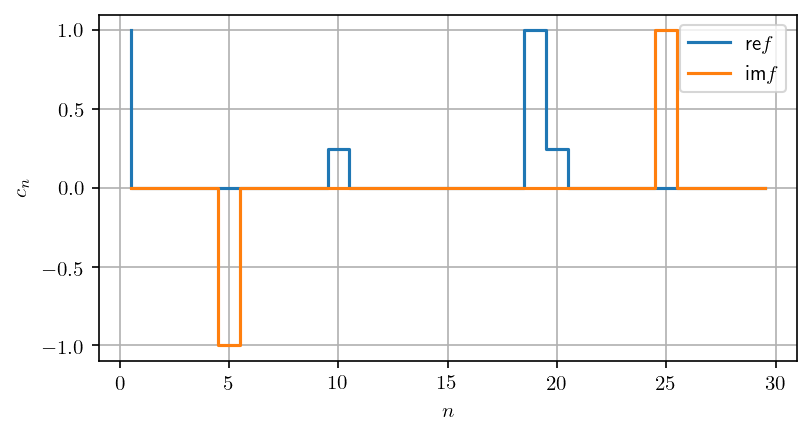

In [15]:
show_Fourier_coeffs(N = 30)

The vector of frequencies:
$$\left[0,1, 2, \ldots, \frac{N}{2}, -\left(\frac{N}{2}-1\right), -\left(\frac{N}{2}-2\right),\ldots,-1\right]\frac{2\pi}{L} $$

Test for the function

$$f(x) = e^{\cos(x)}\;\;\text{for}\;\;x\in[0, 2\pi) $$

$$f'(x) = -\sin(x)e^{\cos(x)}$$

In [16]:
def f(x):
    return np.exp(np.cos(x))

def df(x):
    return -np.sin(x) * np.exp(np.cos(x))

In [17]:
def check_method(D, N):
    x = np.linspace(0, 2*np.pi, N, endpoint=False)
    h = x[1]-x[0]
    F = f(x)
    DF_acc = df(x)
    return [N, D.__name__, D(F, DF_acc, h, N)]

In [18]:
def finite_diff(F, DF_acc,  h, N):  
    n = np.arange(N)
    DF = (F[n-2]-8*F[n-1]+8*F[(n+1)%N]-F[(n+2)%N]) / (12*h)    
    error = np.max(np.abs(DF-DF_acc))
    return error

check_method(finite_diff, 100)

[100, 'finite_diff', 1.2785811246862622e-05]

In [19]:
def spectral_diff(F, DF_acc,  h, N):
    g = np.empty([N,2], dtype=complex)
    k = np.empty(N)
    k[0:N//2+1] = np.arange(N//2+1)
    n = np.arange(1,N//2)
    k[-n] = -k[n]
    ff = 1j*k*np.fft.fft(F)
    DF = np.fft.ifft(ff)
    error = np.max(np.abs(DF-DF_acc))
    return error
    #np.fft.ifft(1j*k*ff)/((N+1)/np.pi)
    print(g)

N = 20    
(check_method(finite_diff, N), check_method(spectral_diff, N)[1:])

([20, 'finite_diff', 0.006597918243649303],
 ['spectral_diff', 5.52844448047955e-09])

In [20]:
def derivative_comparison():
    K = 90
    spec, fin, n = np.empty(K), np.empty(K), np.arange(K)
    for k in n:
        N = k+10
        fin[k] = check_method(finite_diff, N)[2]
        spec[k] = check_method(spectral_diff, N)[2]
    plt.figure(figsize=(6,3), dpi=150)    
    plt.grid(True)    
    plt.semilogy(n+10, fin)
    plt.semilogy(n+10, spec, 'r')
    plt.legend(['finite difference', 'spectral method'])
    plt.xlabel('$N$')
    plt.ylabel('Error')
    plt.show()

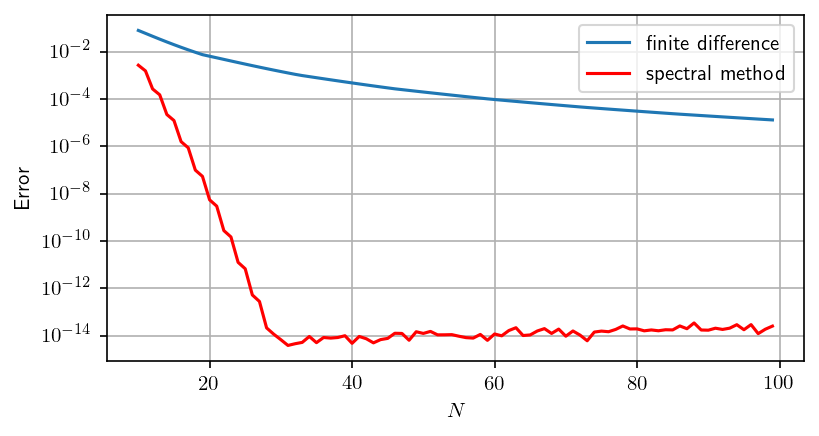

In [21]:
derivative_comparison()

In [22]:
from scipy.fftpack import dct, idct

def spectral_accuracy_problem():
    N=1024;
    x = np.arange(np.pi/(2*N), np.pi, np.pi/N) # (0,pi)
    f = np.heaviside(x-0.25*np.pi, 0)-np.heaviside(x-0.75*np.pi, 0)
    F=dct(f);
    plt.figure(figsize=(10,3), dpi=120)
    plt.subplot(1, 2, 1)
    plt.grid(True)
    n=np.arange(N)
    plt.semilogy(n, F, 'ro');
    plt.legend(['Fourier coefficients']);
    F[50:]=0  # Truncate the Fourier series
    f2=idct(F)/(2*N);

    plt.subplot(1, 2, 2)
    plt.grid(True)
    plt.legend(['exact', 'truncated']);
    plt.plot(x,f, label='exact', color="b");
    plt.plot(x,f2, label='truncated', color='g');
    plt.legend(['exact', 'truncated'])
    plt.show()

#### Gibbs phenomenon

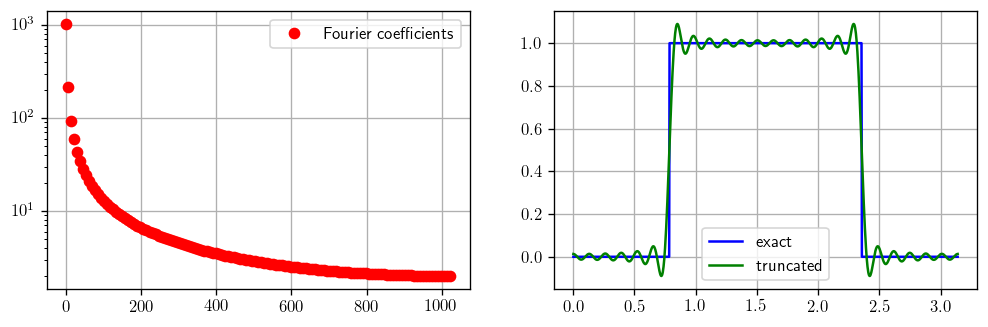

In [23]:
spectral_accuracy_problem()

### Finite difference alternative approach 
 * In fact our first example used also some form of base functions (localized Lagrange polynomials).
   For given interval (three point, five point stencil etc) we approximate a function using  
 $$f(x)=\sum_n^M f(x_n)\ell_{n}(x),\quad \ell_{n}(x) = \prod_{n\neq k}^M\frac{x-x_k}{x_n-x_k}$$
 where $M=2,3$ - low integer (defining the order of the method). Note that $\ell_n(x_k)=\delta_{nk}$<br>
 For $M=2$ for given $n$: $\displaystyle D_{nm}=\ell'_n(x_m)=\left(\ldots, 0, 0, 0, -\frac1h, 0, \frac1h, 0, 0, 0,\ldots\right)$
 

In [24]:
X = np.linspace(-1, 1, 11)
def l(n, x, Xn=X):
    res = 1
    for (k, xn) in enumerate(Xn):
        if k!=n:
            res *= (x-Xn[k])/(Xn[n]-Xn[k])
    return res

def show_lagrange_example():
    x = np.linspace(-1,1, 1000)
    plt.grid(True)
    plt.plot(x, l(1, x))
    plt.plot(x, l(5, x))
    plt.plot(x, l(7, x))
    plt.legend(['$\ell_{1}(x)$', '$\ell_{5}(x)$', '$\ell_{7}(x)$'])
    plt.plot(X, 0*X, 'o')
    plt.plot([X[5], X[7], X[1]], [1, 1, 1], '+')

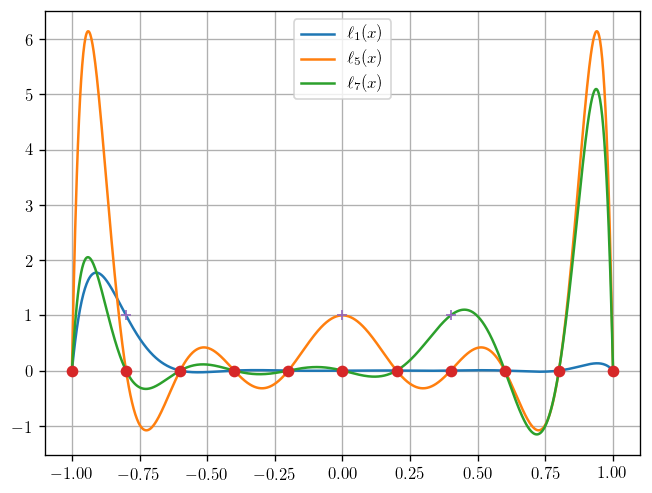

In [25]:
show_lagrange_example()

In [26]:
def show_interpolation_example(F, N=11):
    x = np.linspace(-1,1, 1000)
    X = np.linspace(-1,1, N)
    Y = F(X)
    y = F(x)
    res = 0*x
    for n in range(N):
        res += l(n, x, X)*Y[n]
    plt.grid(True)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.ylim(-0.5, 1.5)
    plt.plot(x, y)
    plt.plot(x, res)
    plt.plot(X, Y, "o")
    plt.legend(['$f(x)$','$f_{aprx}(x)$','col. p.'])
    plt.show()
    return { 'max_error': np.max(np.abs(y-res))}

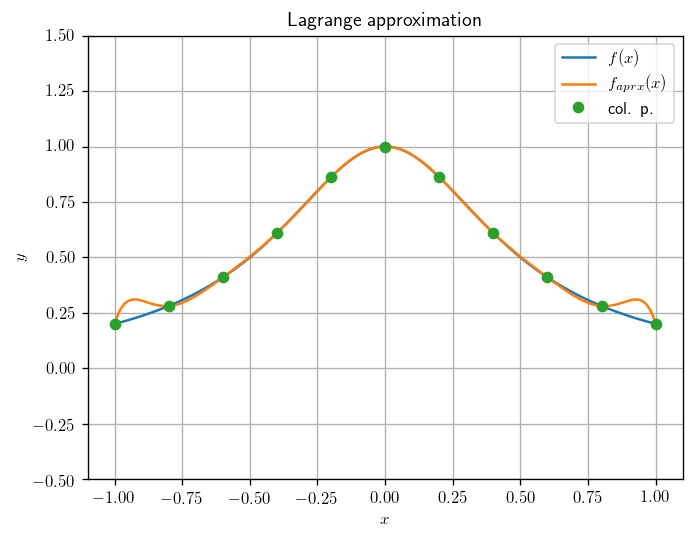

{'max_error': 0.08756747934275841}

In [27]:
def f(x): return 1/(4*x**2+1)
plt.title("Lagrange approximation")
show_interpolation_example(f, N=11)

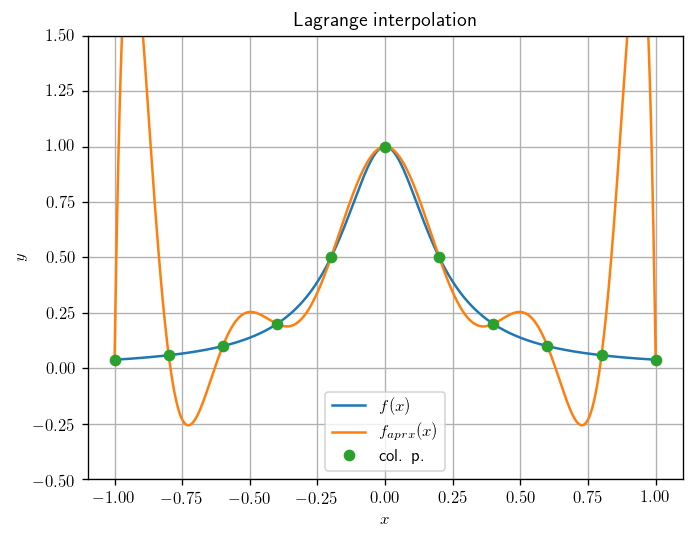

{'max_error': 1.9156331475012054}

In [28]:
def f(x): return 1/(25*x**2+1)
plt.title("Lagrange interpolation")
show_interpolation_example(f, N=11)

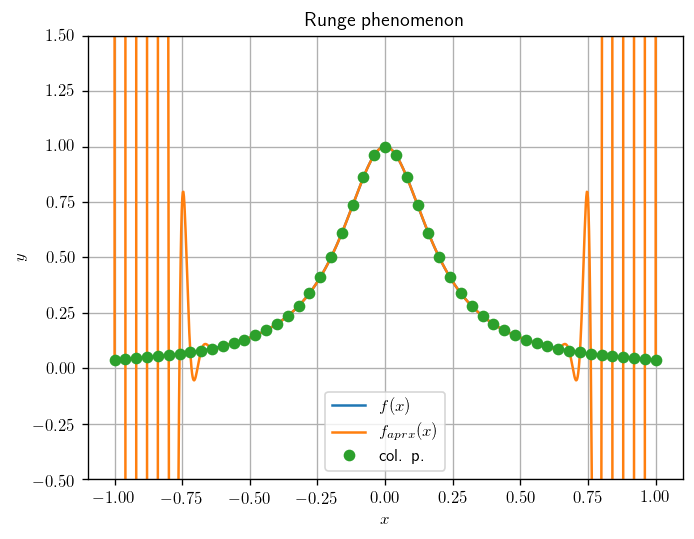

{'max_error': 4817840.128711625}

In [29]:
def f(x): return 1/(25*x**2+1)
plt.title("Runge phenomenon")
show_interpolation_example(f, N=51)

<img src="https://i.imgur.com/dcc6Gsm.jpg">

### Sinc interpolation
For Lagrange interpolation large number of equidistant points lead to Runge phenomenon at the boundaries.

For fast vanishing functions it is possible to use sinc function approximation (no boundary)

$$\text{sinc}(x)=\frac{\sin \pi x}{\pi x}\;,\qquad \text{sinc}(n-m)=\delta_{nm}$$

$$f(x)\approx \sum_{n=-\infty}^{\infty} f(x_n)\, \text{sinc}\left(\frac{x-x_n}{h}\right)\qquad x_n=nh$$

In [30]:
def sinc(x): return np.sin(x*np.pi)/(x*np.pi)
    
import warnings
warnings.filterwarnings('ignore')

def show_sinc_interpolation(F, N):
    x = np.linspace(-1,1, 1000)
    X = np.linspace(-1,1, N)
    h = X[1]-X[0]
    Y = F(X)
    y = F(x)
    res = 0*x
    for n in range(1,N-1):
        res += Y[n] * sinc((x-X[n])/h)
    plt.grid(True)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.ylim(-0.5, 1.5)
    plt.plot(x, y)
    plt.plot(x, res)
    plt.plot(X, Y, "o")
    plt.legend(['$f(x)$','$f_{aprx}(x)$','col. p.'])
    plt.show()    
    return { 'max error': np.max(np.abs(y-res)), 'error without ends': np.max(np.abs(y-res)[100:-100])}

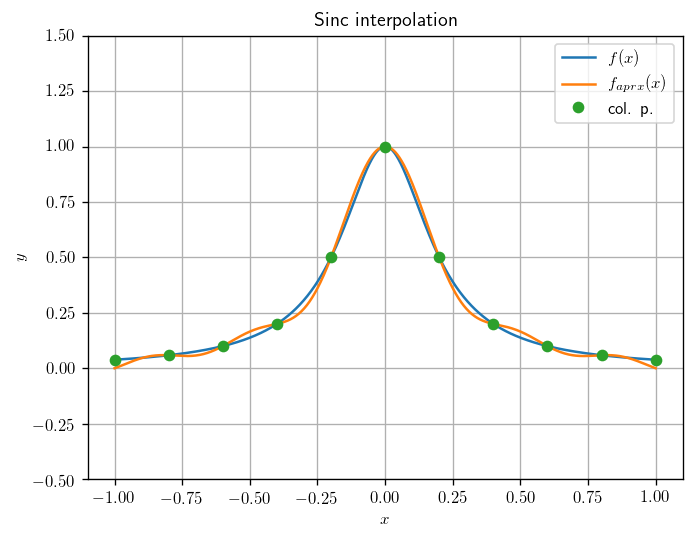

{'max error': 0.03900785760995029, 'error without ends': 0.03900785760995029}

In [31]:
plt.title("Sinc interpolation")
show_sinc_interpolation(f, 11)  

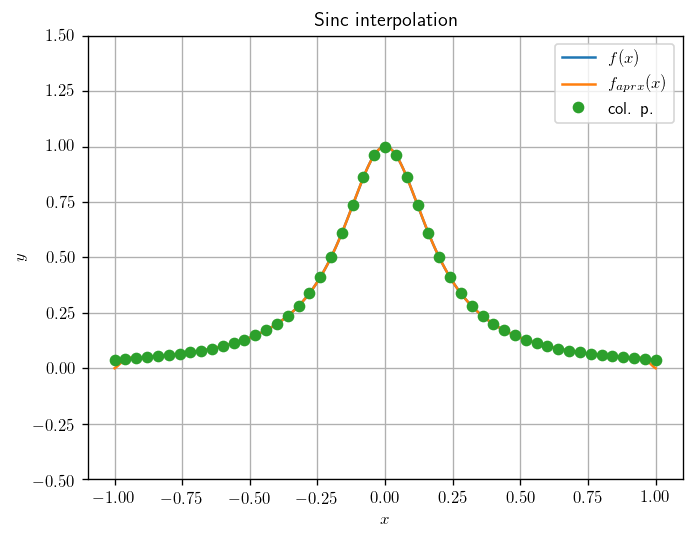

{'max error': 0.038461538461538616,
 'error without ends': 0.0011102094229324191}

In [32]:
plt.title("Sinc interpolation")
show_sinc_interpolation(f, 51)  

From the sinc interpolation a derivative can be calculated:

$$f'(x_m)\approx \sum_{n=-\infty}^{\infty} f_n\, \left.\frac{d}{dx}\text{sinc}\left(\frac{x-x_n}{h}\right)\right|_{x=x_m}=\sum_{n=-\infty}^{\infty} D_{mn}f_n$$

$$D_{m-n}=\frac{1}{h}\left[\cdots, \frac13,-\frac12, 1, 0, -1, \frac12, -\frac13,\cdots\right]$$

or 

$$D_{mn} = \frac{(-1)^{m-n}}{m-n},\;m\neq n\;\;\text{and}\;\;D_{mm}=0$$

Note: The matrix is full not sparse.

Other alternatives (More on that later??? - very important stuff):
* base with finite domain, but nonuniform grid (denser near edges)
    - Chebyshev polynomials 
* infinite base with points spreading out to infinity 
    - rational Chebyshev polynomials

 
 * cubic splines: piecewise defined approximation with cubic polynomial in each segment $Q_n(x), x\in[x_n,x_{n+1}]$ smoothly matched at grid points 
    - $Q_{n-1}(x_n)=Q_n(x_n)$,
    
    - $Q'_{n-1}(x_n)=Q'_n(x_n)$,
    
    - $Q''_{n-1}(x_n)=Q''_n(x_n)$, 
    
this requires solving linear algebraic equation with a tridiagonal matrix.

### Conclusion
- calculating derivatives is not a joke
- interplay between accuracy of difference quotient and machine precision
- finite difference OK, but not too small not too large order (2-6)
- better accuracy using spectral methods (Fourier, sinc, Chebyshev etc)
- spectral methods more difficult, and problem dependent<br>
    periodic, infinite, finite, odd, even etc.    

- can be used to solve ODEs 
    - initial value problem easier, step by step
    - two-point boundary problem can require either shooting or huge system of equations (linear or nonlinear)
    - sparse matrix (finite difference)  are easier to deal with
    - full matrices (spectral methods) give better accuracy 
- needs to be calculated for PDE 
    - method of lines (evolution of huge coupled system of ODE) for hyper- and parabolic PDEs
    - huge system of algebraic equations for elliptic PDE (Laplace)

## Bonus: numerical integration

Using the same Lagrange (or some other polynomial) interpolation:

 $$f(x)=\sum_n^M f(x_n)\ell_{n}(x),\quad \ell_{n}(x) = \prod_{n\neq k}^M\frac{x-x_k}{x_n-x_k}$$
 
 we can easily calculate an integral:
 
 $$
 \int_{x_{0}}^{x_{M-1}}f(x)\,dx = \sum_n^M f(x_n) \int_{x_{0}}^{x_{M-1}}\ell_{n}(x)\,dx=\sum_nA_nf_n
 $$
 
 Where $A_n$ are numbers depending on  a choice of the interpolation points. This is often known as quadratures.<br>
<b> <font color='red'>Important</font>: This can be done only if the integral exists!</b>

In [33]:
def f(x):
    return 1+0.3*np.sin(1.5*x*np.pi)+0.5*x

def Integration_example(f, name, N=5,):
    plt.rcParams['font.size'] = 15
    x = np.linspace(0,1, 1000)
    plt.figure(figsize=(10,5), dpi=120)
    #plt.grid(True)
    plt.plot(x, f(x), color='C1')
    plt.fill_between(x, f(x), 0, alpha = 0.2, color='yellow')
    plt.ylim(0,2)
    plt.title(name)
    X = np.linspace(0,1, N)
    Y = f(X)
    y = f(x)
    res = 0*x
    for n in range(N):
        res += l(n, x, X)*Y[n]
    plt.plot(x, res, color='green')
    plt.plot(X, Y, 'o', color='green')
    plt.fill_between(x, res, 0, alpha = 0.2, color='green')
    plt.vlines(X, 0, Y, colors='black', ls='dashed')
    plt.xticks(X, ['$a$', *[f'$a+h$' if n==1 else f'$a+{n}h$' for n in range(1, len(X)-1)],  '$b$'])
    plt.yticks([],[])
    plt.legend(['$f(x)$', '$f_{aprx}(x)$'])
    for n,xx in enumerate(X):
        plt.text(X[n],Y[n], f'$f_{n}$', position=(X[n], Y[n]+0.06))    
    plt.show()        

In [34]:
import sympy as sm
def quadra(N):
    a, b, h, x = sm.symbols('a b h x')
    X = [ a+n*h for n in range(N) ]
    sm.init_printing()
    #display(X)
    #display(sm.Eq(a, X[1]))
    coeffs = []
    coeffs_diff = []
    for k in range(N):
        l = 1
        for n in range(N):
            if k!=n:
                l *= (x-X[n])/(X[k]-X[n])
        I = sm.integrate(l, (x, X[0], X[-1])).simplify()
        A = sm.symbols(f'A_{k}')
        coeffs.append(sm.Eq(A,I))
        df = sm.diff(l, x).subs(x, X[0]).simplify()
        c = sm.symbols(f'c_{k}')
        coeffs_diff.append(sm.Eq(c,df))
        #display(sm.Eq(A,I))
    print('Quadrature:')
    display(coeffs)
    print('Foreward finite difference coefficiens for f:')
    display(coeffs_diff)

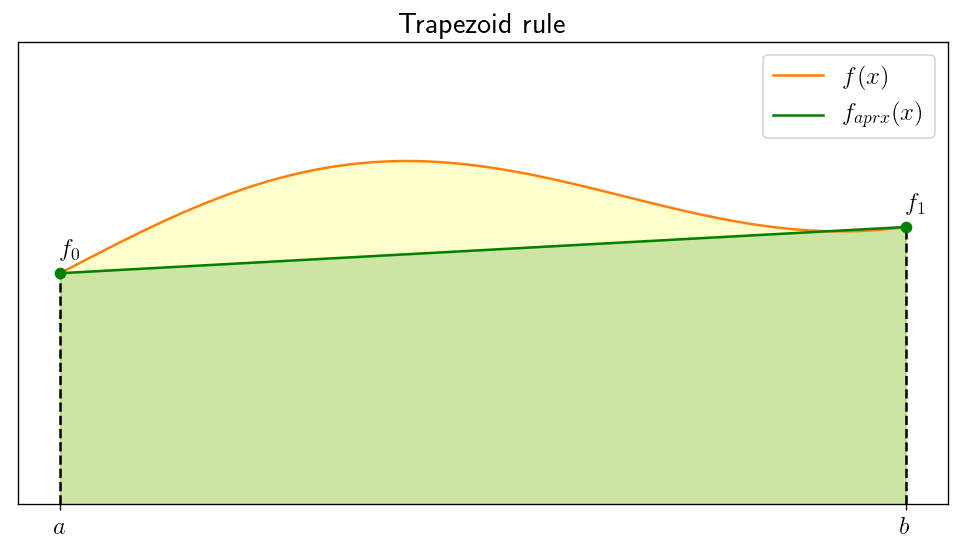

Quadrature:


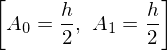

Foreward finite difference coefficiens for f:


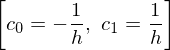

In [35]:
Integration_example(f, 'Trapezoid rule', 2)
quadra(2)

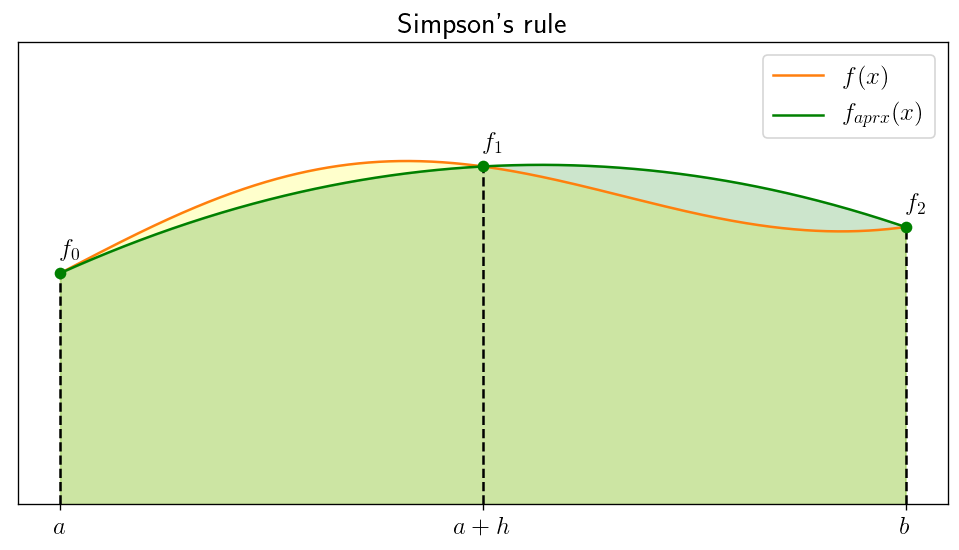

Quadrature:


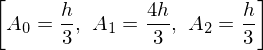

Foreward finite difference coefficiens for f:


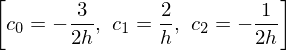

In [36]:
Integration_example(f, "Simpson's rule", 3)
quadra(3)

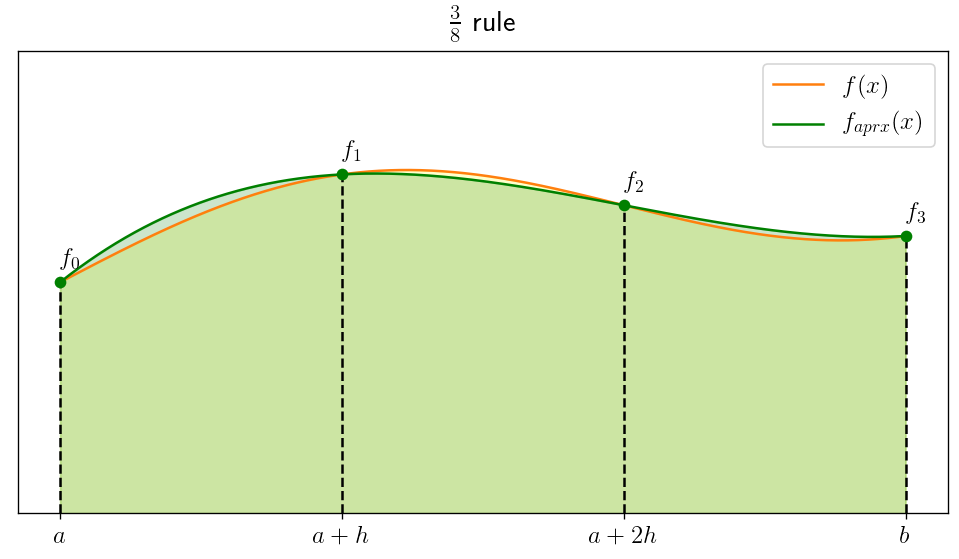

Quadrature:


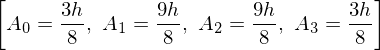

Foreward finite difference coefficiens for f:


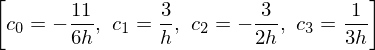

In [37]:
Integration_example(f, r'$\frac38$ rule', 4)
quadra(4)

Because of symmetries the errors are odd powers of the interval lengths:

$$E_{trap} = -\frac{(b-a)^3}{12}f''(\xi)$$

$$E_{Sims} = -\frac{(b-a)^5}{2880}f^{(4)}(\xi)$$

$$E_{3/8} = -\frac{(b-a)^5}{6480}f^{(4)}(\xi)$$


Better: divide into smaller segments (composite methods)


$$E_{Sims}(N) = -N\frac{(b-a)^5}{2880N^5}f^{(4)}(\xi)=\mathcal{O}\left(N^{-4}\right)$$

Even better: use adaptive methods - divide when the error within a segment which give large errors.


### Tasks:
1. Implement automatic differentiation class and overload basic operators and 4+ functions
1. Test finite difference method for $f(x)=\sin(x)$ at $x=1$ (find optimal $h$).
1. Calculate numerically integrals
$$\int_{0}^1\frac{\log(1+x)}{\sqrt{1+x^2}}dx$$
<br>

$$\int_{0}^1\frac{\log(1+x)}{\sqrt{1-x^2}}dx$$

<br>
using composite Simpson's rule with accuracy better than $10^{-6}$.

4. Using first order differential scheme 

$$y'_n\approx \frac{y_{n+1}-y_n}{h}$$ 

<br>

for $y_0=1$ and $x\in [0,10]$
solve the differential equation $y' = ky$  in $x\in[0,10]$ with boundary conditions $y(0)=1$.<br> Experiment with different choices of $k<0$ and $h$. When the method gives completely wrong results? Plot the solutions. 

5. Solve the equation $y''+0.1y'+y=0$ with conditions $y(0)=1$, $y'(0)=0$. What kind of scheme can you use?
6. Solve the same equation rewriting the above equation for as a first order _vector_ equation
$$u_n=\left(\begin{array}{c}y_n\\y'_n\end{array}\right)$$
7. What strategies could you use to solve the equation
    $$y''+y=0, \;\;y(0) = y(1) = 1?$$